# LH012 ⬛ Audible Data Cleaning 

>  **Note**: this tutorial is provided for educational purposes, for members of the [Fabric Dojo community](https://skool.com). All content contained within is protected by Copyright © law. Do not copy or re-distribute. 

In a Dataflow tutorial (DF005), we used the Dataflow Gen2 to clean some messy data, and we saw that it was quite a complex data cleaning task in a Dataflow. 

Now, let's do the same exercise, but this time, we'll use Spark. 

#### Prerequisites
1. You should already have a Lakehouse in your Fabric Workspace - you can continue using the LH007_PropertyLH Lakehouse for this task. 
2. Load this notebook into your Fabric Workspace. Connect this notebook to the LH007_PropertyLH Lakehouse. 
3. Download the LH012_audible_uncleaned.csv file from the Skool tutorial page, upload the file into your Lakehouse Files area. 

#### Data loading from CSV

**Run the script below to load the `LH012_audible_uncleaned.csv` file from `Files/` into a Spark dataframe.** 

Familiarise yourself with the structure of the dataframe.  


# Note: in this solution notebook, I use a verbose style to show the result of each column transformation, one-at-a-time, to try to make it easier to follow what is happening at each step. 


In [1]:
df0 = (
    spark.read.format("csv")
        .option("header","true")
        .option("inferSchema", True)
        .load("Files/LH012_audible_uncleaned.csv")
)

display(df0)


StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 3, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 6098d7b1-82ba-4f5d-9db9-13efa891c1cc)

#### Task: Clean the data! 

Your task is to use all your knowledge you've gained so far (and maybe some more!) to create a new, cleaned dataframe called `audible_cleaned` (**Important that you call the final output dataframe `audible_cleaned`, because that's what the validation script uses**). 

Your `audible_cleaned` dataframe should align to the following requirements: 

The final dataset should have the following columns: 
- AudiobookId - integer value from 0, rising upwards
- BookName - the name of the (audio) book
- PrimaryAuthor - the name of the Primary Author (the first one mentioned), with space-separated name like "Rick Riordan" 
- DurationMinutes - the total length of the audiobook in minutes
- ReleaseDate - the release data of the Audiobook 
- Language - the language of the Audiobook
- Price - an integer value from the price column
- Rating - a representation of the Rating (of type Float)
- NoOfRatings - from the stars column - integer value. 

You can use the following image as a guide:


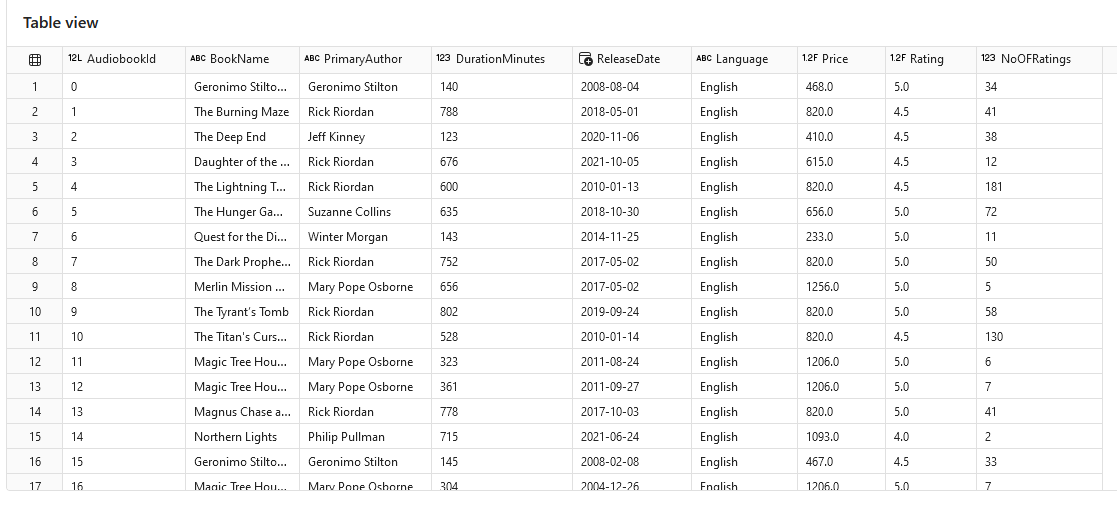

#### Validation 

At the bottom of this notebook, I have included a validation function. 

Pass your final dataset into the function (as a Spark Dataframe). If you pass all the tests, you have successfully passed this tutorial. 

#### Your code goes here: 👇

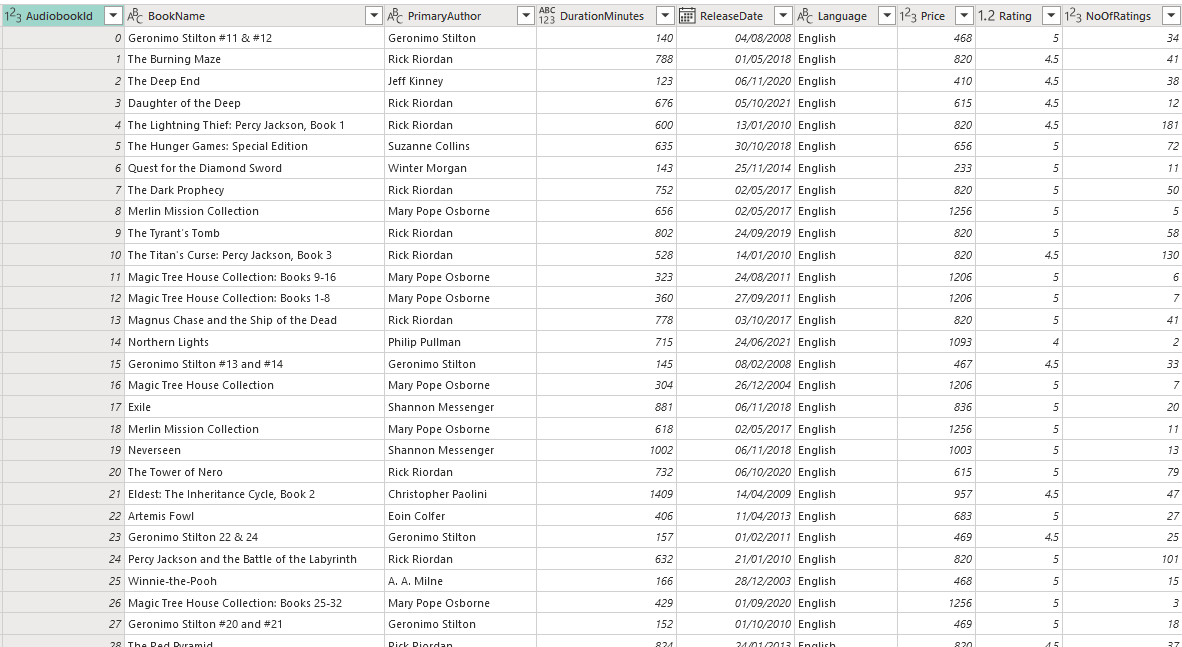

PrimaryAuthor column

In [3]:
from pyspark.sql.functions import regexp_replace, split, col

df1 = (
    df0
        .withColumn("author", regexp_replace(col("author"), "^Writtenby:", ""))
        .withColumn("author", split(col("author"), ",")[0])
        .withColumn("author", regexp_replace(col("author"), "([a-z])([A-Z])", "$1 $2"))
        .withColumnsRenamed({"name": "BookName", "author": "PrimaryAuthor"})
)

display(df1)

StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ea4de605-65b9-4271-aca8-87b5363e3327)

Removing the Narrator column 

In [4]:
df2 = df1.drop('narrator')

StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 6, Finished, Available, Finished)

DurationMinutes column:

In [5]:
from pyspark.sql.functions import regexp_extract, col, when

df3 = (
    df2
        .withColumn("hours", regexp_extract(col("time"), r"(\d+)\s*hr", 1).cast("int")) 
        .withColumn("minutes", regexp_extract(col("time"), r"(\d+)\s*min", 1).cast("int"))
        .fillna({"hours": 0, "minutes": 0})
        .withColumn("DurationMinutes", (col("hours") * 60) + col("minutes"))
        .drop("hours", "minutes", "time")
)

display(df3)

StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 636e67b9-ac9d-40d7-98bf-26ff4f0a37ce)

ReleaseDate column: 

In [6]:
from pyspark.sql.functions import to_date

df4 = df3.withColumn("ReleaseDate", to_date("releasedate", "dd-MM-yy"))

display(df4)

StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, aa9d621f-8bb6-49f4-9f79-9cee79a67daa)

Language column:

In [7]:
df5 = df4.withColumnRenamed("language", "Language") 

display(df5)

StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 9, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 96f4aa13-30d7-448e-9f0b-093eadab296d)

Rating column:

In [8]:
df6 = (
    df5
        .withColumn("Rating", 
            when(col("stars").contains("Not rated yet"), None)
            .otherwise(regexp_extract("stars", r"(\d+(\.\d+)?)\s+out", 1)
        .cast("float")
        )
    )
)
display(df6)

StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 10, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7f4503aa-998a-41e9-90e3-0f7aaa693c6b)

NoOfRatings Column: 

_Note: after the video recording, I have updated the regular expression here to account for the case where the number of ratings is just 1_

In [9]:
df7 = (
    df6
        .withColumn("NoOfRatings", 
            when(col("stars").contains("Not rated yet"), 0)
                .otherwise(regexp_extract("stars", r"(\d+)\s+rating[s]?$", 1)
        .cast("int"))
        
    )
    .drop('stars')
   
)

display(df7)

StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 11, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 64a8a00a-ca9d-4608-827b-8c1b7c6f4dfb)

Price column: 

In [10]:
df8 = (
    df7
        .withColumn("Price", when(col("price") == "Free", 0)
            .otherwise(regexp_replace(col("price"), ",", ""))
        .cast("float")
    )  
)

display(df8)

StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 12, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 620293a3-f9f8-40be-bf90-356b304daf72)

AudiobookId column: 

In [11]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

windowSpec = Window.orderBy(F.lit(1))  
df9 = df8.withColumn("AudiobookId", F.row_number().over(windowSpec) - 1)

display(df9)

StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 13, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 1714d716-8285-40e8-b422-4f4452ea3715)

Rearranging the columns: 

In [12]:
audible_cleaned = df9.select("AudiobookId", "BookName", "PrimaryAuthor", "DurationMinutes", "ReleaseDate", "Language", "Price", "Rating", "NoOFRatings")

display(audible_cleaned)


StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 14, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 117d2a06-bbb4-4c55-9d6a-5a6cd9f750ce)

#### Validation script

Instructions: 
1. Run the following validation cell. It will test your `audible_cleaned` dataframe, and if you pass all the tests, the function will return a PASS!  
2. Check the output at the bottom of the cell - if you see five PASSES, congrats!  

In [13]:
from pyspark.sql import functions as F
import datetime

# Expected schema and values for the tests
EXPECTED_DTYPES = [
    ('AudiobookId', 'int'),
    ('BookName', 'string'),
    ('PrimaryAuthor', 'string'),
    ('DurationMinutes', 'int'),
    ('ReleaseDate', 'date'),
    ('Language', 'string'),
    ('Price', 'float'),
    ('Rating', 'float'),
    ('NoOFRatings', 'int')
]

EXPECTED_MAX_AUDIOBOOK_ID = 87488

EXPECTED_VALUES = {
    5250: {
        'AudiobookId': 5250,
        'BookName': 'The Icebound Land',
        'PrimaryAuthor': 'John Flanagan',
        'DurationMinutes': 462,
        'ReleaseDate': datetime.date(2010, 10, 22),
        'Language': 'English',
        'Price': 702.0,
        'Rating': 5.0,
        'NoOFRatings': 1
    },
    1692: {
        'AudiobookId': 1692,
        'BookName': 'I Am Hatzegopteryx',
        'PrimaryAuthor': 'Tim Bradley',
        'DurationMinutes': 1,
        'ReleaseDate': datetime.date(2021, 12, 15),
        'Language': 'English',
        'Price': 47.0,
        'Rating': None,
        'NoOFRatings': 0
    },
    69804: {
        'AudiobookId': 69804,
        'BookName': 'The Passion Test',
        'PrimaryAuthor': 'Janet Bray Attwood',
        'DurationMinutes': 349,
        'ReleaseDate': datetime.date(2006, 9, 11),
        'Language': 'English',
        'Price': 585.0,
        'Rating': 4.5,
        'NoOFRatings': 6
    }
}

# Test Functions
def test_schema(audible_cleaned):
    result = "Test Passed" if audible_cleaned.dtypes == EXPECTED_DTYPES else "Test Failed: Schema does not match the expected schema."
    print(f"Test (Schema): {result}")

def test_max_audiobook_id(audible_cleaned):
    max_value = audible_cleaned.agg(F.max("AudiobookId")).collect()[0][0]
    result = "Test Passed" if max_value == EXPECTED_MAX_AUDIOBOOK_ID else f"Test Failed: Max AudiobookId is {max_value}, expected {EXPECTED_MAX_AUDIOBOOK_ID}."
    print(f"Test (Max AudiobookId): {result}")

def test_row_values(audible_cleaned, audiobook_id, expected_values):
    actual_values = audible_cleaned.filter(audible_cleaned.AudiobookId == audiobook_id).collect()[0].asDict()
    result = "Test Passed" if actual_values == expected_values else f"Test Failed: AudiobookId {audiobook_id} values do not match expected values."
    print(f"Test (Values Test for AudiobookId {audiobook_id}): {result}")

# Running the tests
def run_tests(audible_cleaned):
    test_schema(audible_cleaned)
    test_max_audiobook_id(audible_cleaned)
    for audiobook_id, expected_values in EXPECTED_VALUES.items():
        test_row_values(audible_cleaned, audiobook_id, expected_values)

# Execute tests
run_tests(audible_cleaned)


StatementMeta(, be3a622f-1508-4c84-8bab-38ac865f4757, 15, Finished, Available, Finished)

Test (Schema): Test Passed
Test (Max AudiobookId): Test Passed
Test (Values Test for AudiobookId 5250): Test Passed
Test (Values Test for AudiobookId 1692): Test Passed
Test (Values Test for AudiobookId 69804): Test Passed
